In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sachinkumar413_diabetic_retinopathy_dataset_path = kagglehub.dataset_download('sachinkumar413/diabetic-retinopathy-dataset')

print('Data source import complete.')


Data source import complete.


# About Dataset

## Total Class Labels = 5

## Total Images = 2750

### 1. Healthy (Not DR) = 1000

### 2. Mild DR = 370

### 3. Moderate DR = 900

### 4. Proliferative DR = 290

### 5. Severe DR = 190

### DR: Diabetic Retinopathy



>


### Diabetic retinopathy is a complication of diabetes and a leading cause of blindness. It occurs when diabetes damages the tiny blood vessels inside the retina, the light-sensitive tissue at the back of the eye. A healthy retina is necessary for good vision.
If you have diabetic retinopathy, at first you may notice no changes to your vision. But over time, diabetic retinopathy can get worse and cause vision loss. Diabetic retinopathy usually affects both eyes.

### Diabetic Retinopathy has four stages:

## Mild Nonproliferative Retinopathy
At this earliest stage, microaneurysms occur. They are small areas of balloon-like swelling in the retina’s tiny blood vessels.

## Moderate Nonproliferative Retinopathy
As the disease progresses, some blood vessels that nourish the retina are blocked.

## Severe Nonproliferative Retinopathy
Many more blood vessels are blocked, depriving several areas of the retina with their blood supply. These areas of the retina send signals to the body to grow new blood vessels for nourishment.

## Proliferative Retinopathy
At this advanced stage, the signals sent by the retina for nourishment trigger the growth of new blood vessels. These new blood vessels are abnormal and fragile. They grow along the retina and along the surface of the clear, vitreous gel that fills the inside of the eye.

By themselves, these blood vessels do not cause symptoms or vision loss. However, they have thin, fragile walls. If they leak blood, severe vision loss and even blindness can result.

ref: https://petroueyecare.com/services/medical-eye-exams/diabetic-retinopathy/



# 1 Import libraries

In [2]:
!pip install -U imbalanced-learn

import os
import shutil
import pathlib
import PIL
import cv2
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import random
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow .keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from PIL import Image, UnidentifiedImageError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


print("All done")

All done


# 2 Read Data

## A- convert files to lists

In [3]:
Path_data = '/kaggle/input/diabetic-retinopathy-dataset'
data = os.listdir(Path_data)
Healthy = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Healthy')
Mild = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Mild DR')
Moderate = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Moderate DR')
Proliferate = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Proliferate DR')
Severe = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Severe DR')

In [4]:
print("classes names :", (data), "\n______________________________\n")
print("Number of classes :", len(data), "\n______________________________\n")
print("Number of Healty images :", len(Healthy), "\n______________________________\n")
print("Number of Mild images :", len(Mild),  "\n______________________________\n")
print("Number of Moderate images :", len(Moderate),  "\n______________________________\n")
print("Number of Proliferate images :", len(Proliferate),  "\n______________________________\n")
print("Number of severe images :", len(Severe),  "\n______________________________\n")

classes names : ['Severe DR', 'Healthy', 'Moderate DR', 'Mild DR', 'Proliferate DR'] 
______________________________

Number of classes : 5 
______________________________

Number of Healty images : 1000 
______________________________

Number of Mild images : 370 
______________________________

Number of Moderate images : 900 
______________________________

Number of Proliferate images : 290 
______________________________

Number of severe images : 190 
______________________________



### As noticed above: data  imbalanced

## B- Create a dataframe

# 3 Data Preptocessing

In [5]:
# Get Paths

Path_data = '/kaggle/input/diabetic-retinopathy-dataset'

# Create two lists to store paths of images and their labels

imgpaths = []
labels =[]


# Convert directory to list

data = os.listdir(Path_data)

# Get paths and Labels of classes and images in data

for i in data:
    classpath = os.path.join(Path_data, i)
    imglist = os.listdir(classpath)

    for img in imglist:
        imgpath = os.path.join(classpath, img)

        imgpaths.append(imgpath)
        labels.append(i)


# Convert two lists of imgpaths and their labels into series

Paths = pd.Series(imgpaths, name = 'Paths')
Labels = pd.Series(labels, name = 'Labels')

# Concatenate them in one Dataframe called Tr_data

Df= pd.concat([Paths, Labels], axis = 1)
Df.head(5)

,Paths,Labels
0,/kaggle/input/diabetic-retinopathy-dataset/Sev...,Severe DR
1,/kaggle/input/diabetic-retinopathy-dataset/Sev...,Severe DR
2,/kaggle/input/diabetic-retinopathy-dataset/Sev...,Severe DR
3,/kaggle/input/diabetic-retinopathy-dataset/Sev...,Severe DR
4,/kaggle/input/diabetic-retinopathy-dataset/Sev...,Severe DR


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('Paths').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

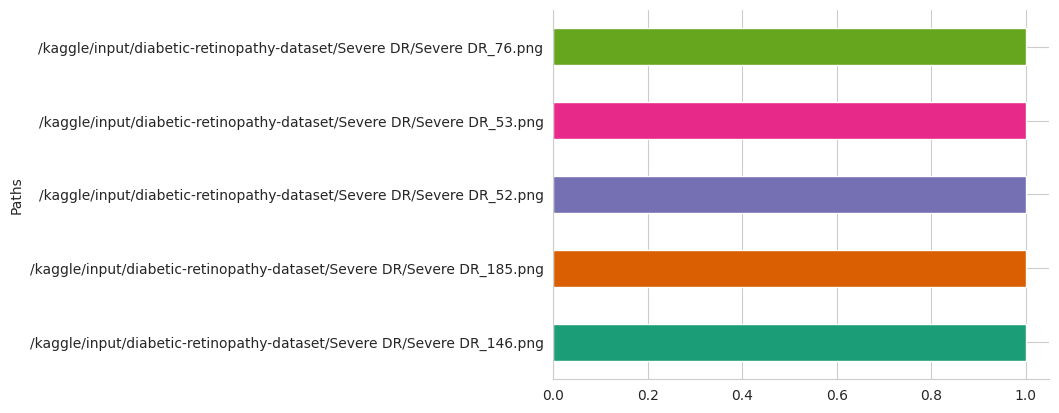

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('Paths').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

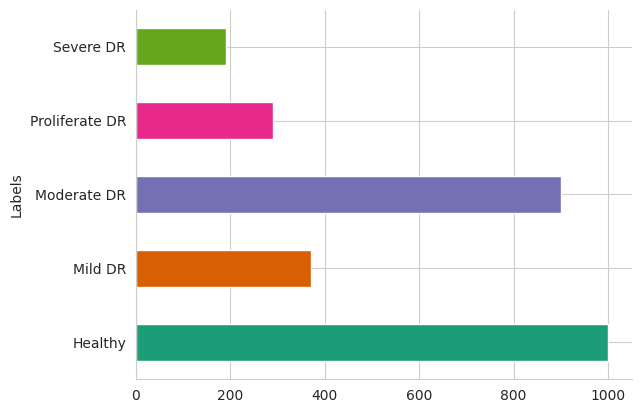

In [7]:
# @title Labels

from matplotlib import pyplot as plt
import seaborn as sns
Df.groupby('Labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [6]:
# prompt: Using dataframe Df: bar graph

import altair as alt

# Count the occurrences of each label
label_counts = Df['Labels'].value_counts().reset_index()
label_counts.columns = ['Labels', 'Count']

# Create the bar chart
chart = alt.Chart(label_counts).mark_bar().encode(
    x='Labels',
    y='Count'
).properties(title='Distribution of Diabetic Retinopathy Labels')

chart


alt.Chart(...)

## B- Split data into train, valid, test

In [9]:
#train, valid  and test dataframes
train, testval = train_test_split(Df, test_size = 0.2, shuffle = True, random_state = 123)
valid, test = train_test_split(testval, test_size = 0.5, shuffle = True, random_state = 123)

print("Train shape: ", train.shape)
print("Valid shape: ", valid.shape)
print("Test shape: ",test.shape)

train.Labels.value_counts()

Train shape:  (2200, 2)
Valid shape:  (275, 2)
Test shape:  (275, 2)


,count
Labels,
Healthy,796
Moderate DR,724
Mild DR,290
Proliferate DR,236
Severe DR,154


## C- Data Augmentation

In [10]:
batch_size = 20   # As smaller, As more data generated ....In views of data size
img_size = (224, 224) # standard value (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


#Create generators

tr_G = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30.,
    fill_mode='nearest',
    )

V_G = ImageDataGenerator()

t_G = ImageDataGenerator()

#Generate Appropriate Data for fitting into model

Train = tr_G.flow_from_dataframe(train, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Valid = V_G.flow_from_dataframe(valid, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Test = t_G.flow_from_dataframe(test, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 2200 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.


## D- Represent a sample

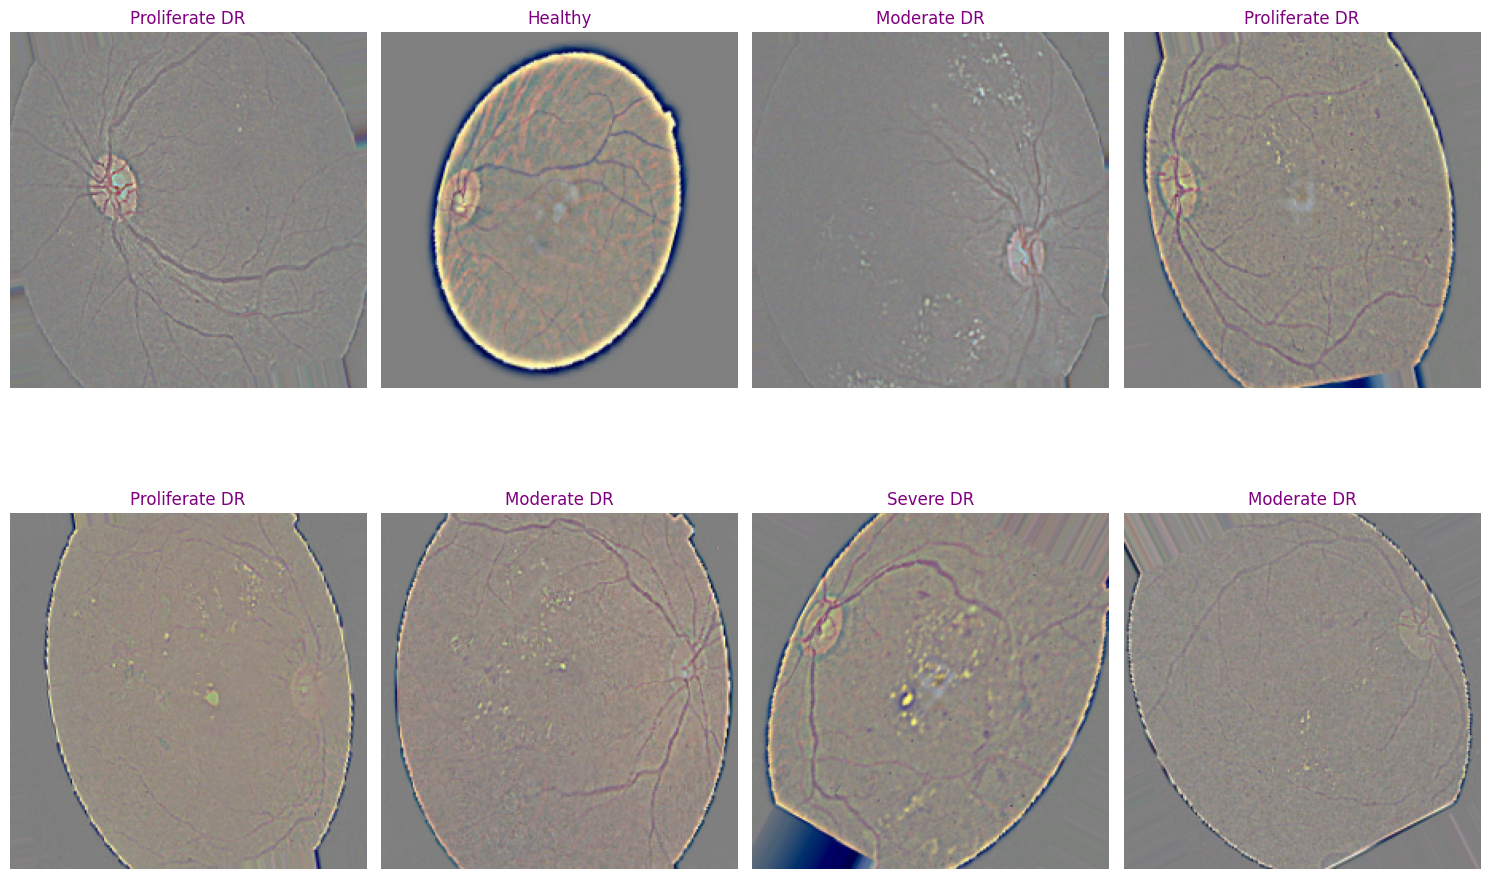

In [11]:
# Define labels and their indices as a dict
L_index = Train.class_indices
L_index

# Store Labels in a list
Keys = list(L_index.keys())
Keys

#Get a sample batch
imgs, labels = next(Train)

# Visualization
plt.figure(figsize= (15, 15))

for i in range(8):
    plt.subplot(3, 4, i +1)
    im = imgs[i]/255
    plt.imshow(im)

    #Labelling
    index = np.argmax(labels[i])
    label = Keys[index]
    plt.title(label, color = 'purple')
    plt.axis('off')

plt.tight_layout()
plt.show()

# 4 Modelling

## A- Create a model using transfer learning with EfficientNetB2


In [13]:
# Define number of classes
n_classes = len(list(Train.class_indices.keys()))
n_classes

img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model= EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')

# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.999, epsilon=0.001 )(x)
x = Dense(1024, kernel_regularizer = regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.005), # The regularization strength for l2 should be passed as a positional argument
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.2, seed=123)(x)
x = Dense(512, kernel_regularizer = regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.005), # The regularization strength for l2 should be passed as a positional argument
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)
x = Dense(256, kernel_regularizer = regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.005), # The regularization strength for l2 should be passed as a positional argument
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)
output=Dense(n_classes, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.0001 # start with this learning rate

In [14]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='elu'))
model.add(Dense(256, activation='elu'))
model.add(Dense(128, activation = 'elu'))
model.add(Dense(5, activation='softmax'))


In [15]:
model.compile(
    Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,735,348 (44.77 MB)

 Trainable params: 11,648,045 (44.43 MB)

 Non-trainable params: 87,303 (341.03 KB)

## B- Visualize model layers

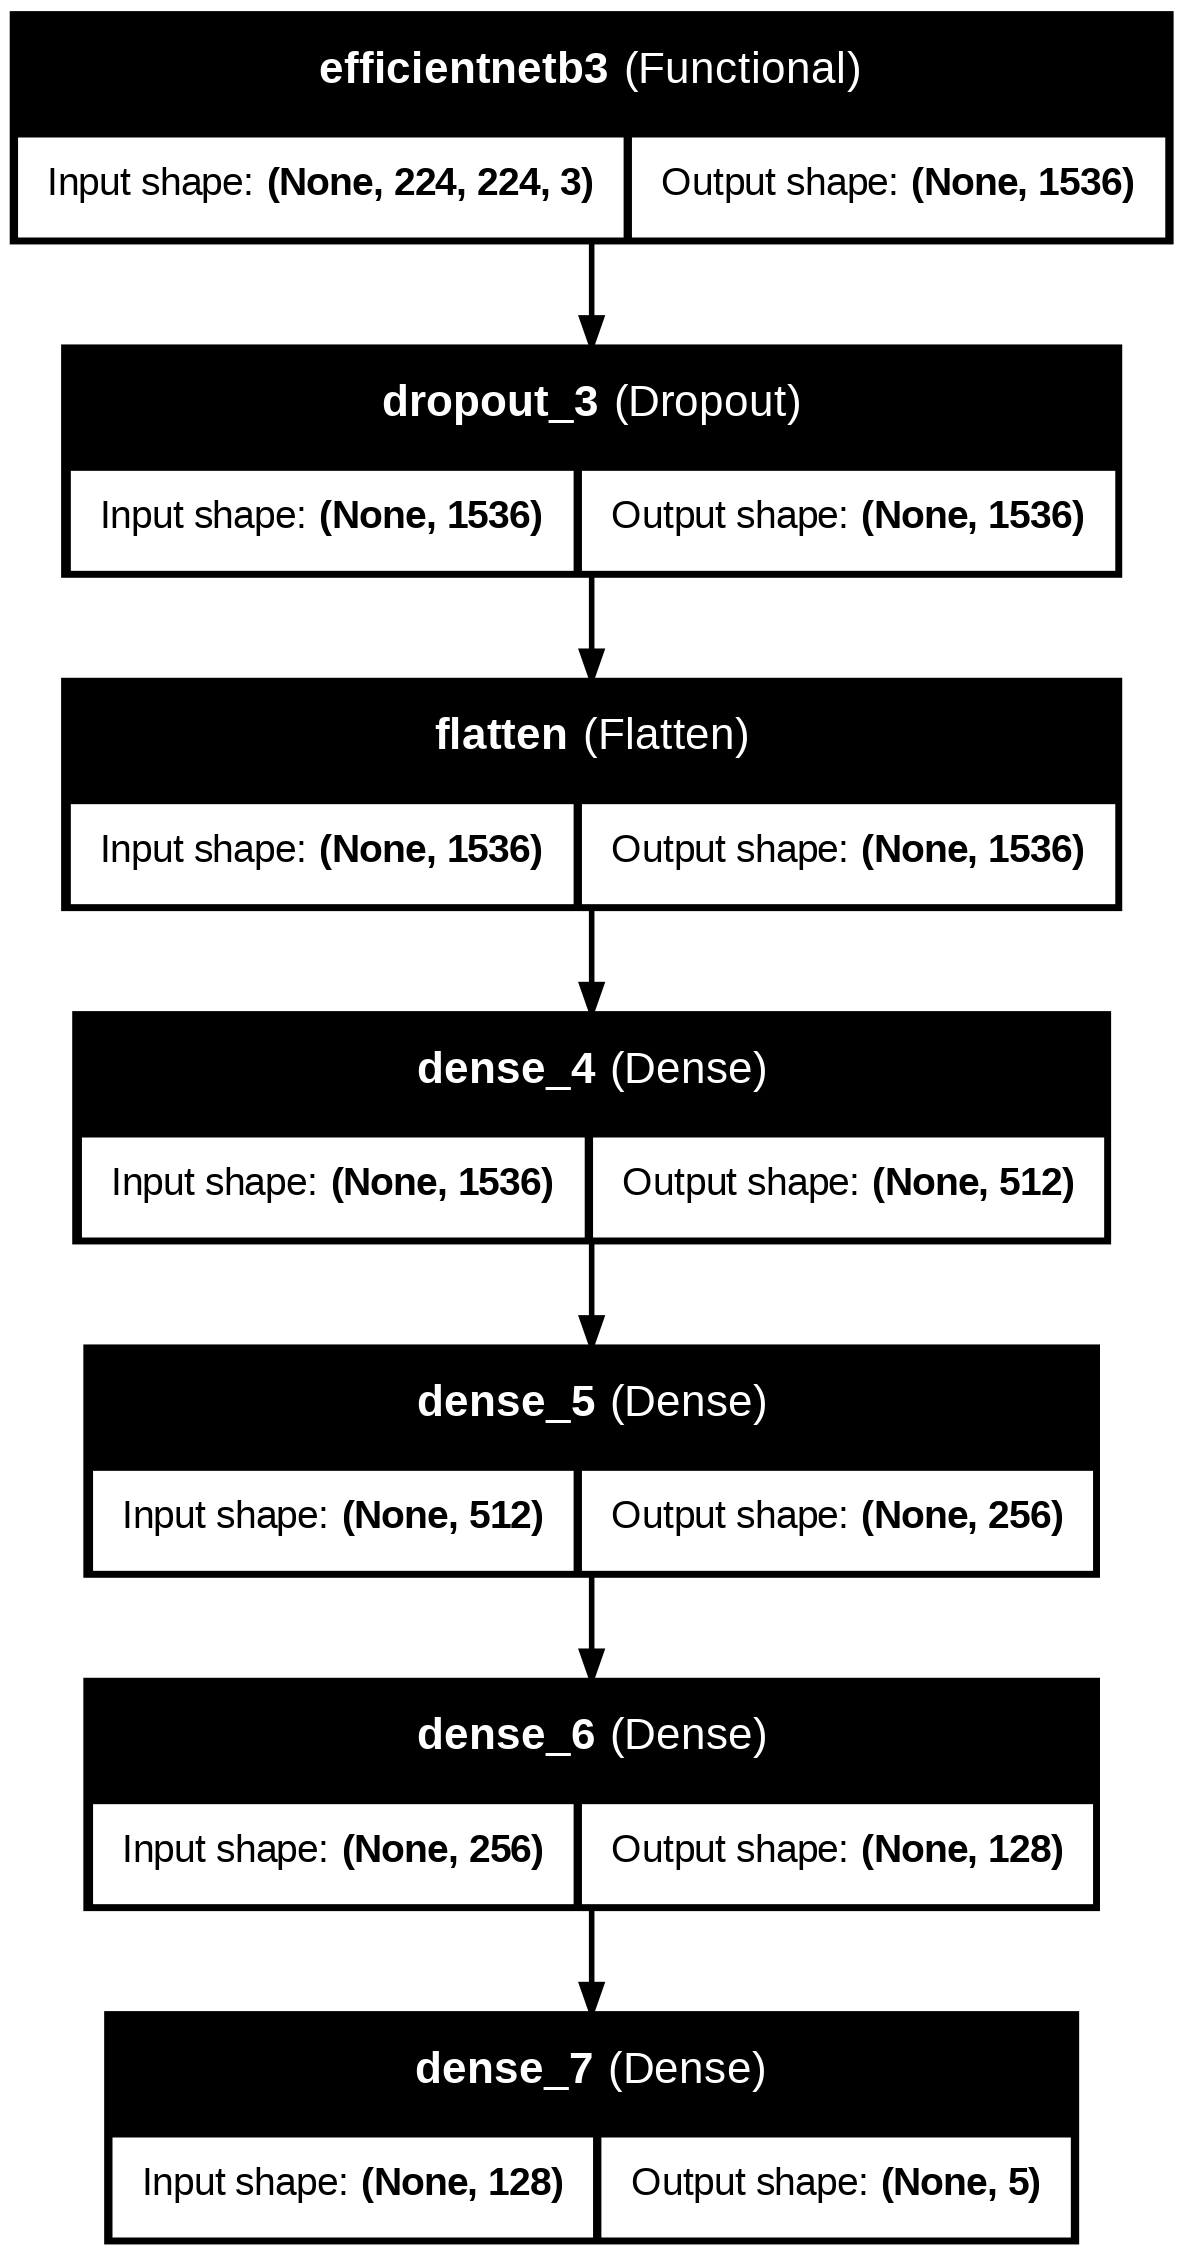

In [17]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

## C- Training phase

In [18]:
epochs = 5
history = model.fit(x= Train, epochs= epochs, verbose= 1, validation_data= Valid, validation_steps= None, shuffle= False)

Epoch 1/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 1346s 11s/step - acc: 0.4251 - loss: 2.0727 - val_acc: 0.5055 - val_loss: 1.3233
Epoch 2/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 1246s 11s/step - acc: 0.5773 - loss: 1.2517 - val_acc: 0.6400 - val_loss: 0.9884
Epoch 3/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 1234s 11s/step - acc: 0.6136 - loss: 1.0423 - val_acc: 0.6836 - val_loss: 0.8673
Epoch 4/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 1225s 11s/step - acc: 0.6174 - loss: 1.0242 - val_acc: 0.6873 - val_loss: 0.8340
Epoch 5/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 1240s 11s/step - acc: 0.6698 - loss: 0.8991 - val_acc: 0.6800 - val_loss: 0.8360


## D- Evaluation

In [20]:
import os

# Create the directory if it doesn't exist
os.makedirs('/kaggle/working/', exist_ok=True)

# Now save the model weights
model.save_weights('/kaggle/working/diabetic_model_weights.weights.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class: Moderate


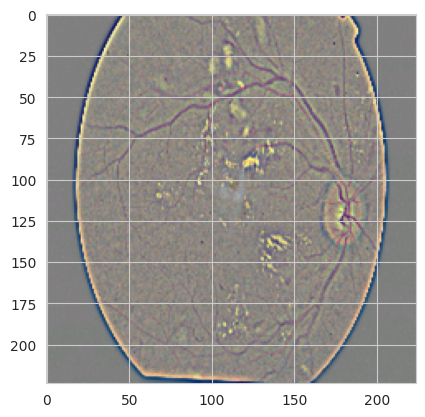

In [21]:
model.load_weights('/kaggle/working/diabetic_model_weights.weights.h5')

from PIL import Image
prediction_datagen = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30,
    fill_mode='nearest',

)
def preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img = np.array(img)
    img = np.expand_dims(img, axis=0)  # Model expects a batch of images
    img = img / 255.0  # Normalize the image
    return img


# Function to preprocess and predict an image
def preprocess_and_predict(image_path, model):
    # Load the image
    img = Image.open(image_path).convert('RGB')
    img = img.resize(img_size)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess the image using the prediction ImageDataGenerator
    img_preprocessed = next(prediction_datagen.flow(img_array, batch_size=1))

    # Predict
    prediction = model.predict(img_preprocessed)
    predicted_class = np.argmax(prediction, axis=1)

    return predicted_class, img


# Example usage
image_path = '/kaggle/input/diabetic-retinopathy-dataset/Severe DR/Severe DR_104.png'  # Replace with your image path
predicted_class, predictions =preprocess_and_predict(image_path,model)

# Define the class names
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

import matplotlib.pyplot as plt
# Print the results

print(f"Predicted class: {class_names[predicted_class[0]]}")
plt.imshow(predictions)

In [22]:
# accuracy and loss of Train

tr_acc = history.history['acc']
tr_loss = history.history['loss']


# accuracy and loss or Valid\

v_acc = history.history['val_acc']
v_loss = history.history['val_loss']


# highest value of v_acc by getting its index

index_acc = np.argmax(v_acc)
high_Vacc = v_acc[index_acc]


# lowest value of v_loss by getting index

index_loss = np.argmin(v_loss)
low_Vloss = v_loss[index_loss]


# n. of epochs based on length of tr_acc values

Epochs =[]
for i in range(len(tr_acc)):
    Epochs.append (i+1)


# Define best epoch

best_acc = f'Best epoch ={str(index_acc +1)}'
best_loss = f'Best epoch ={str(index_loss+1)}'

## E- Let's Visualize it

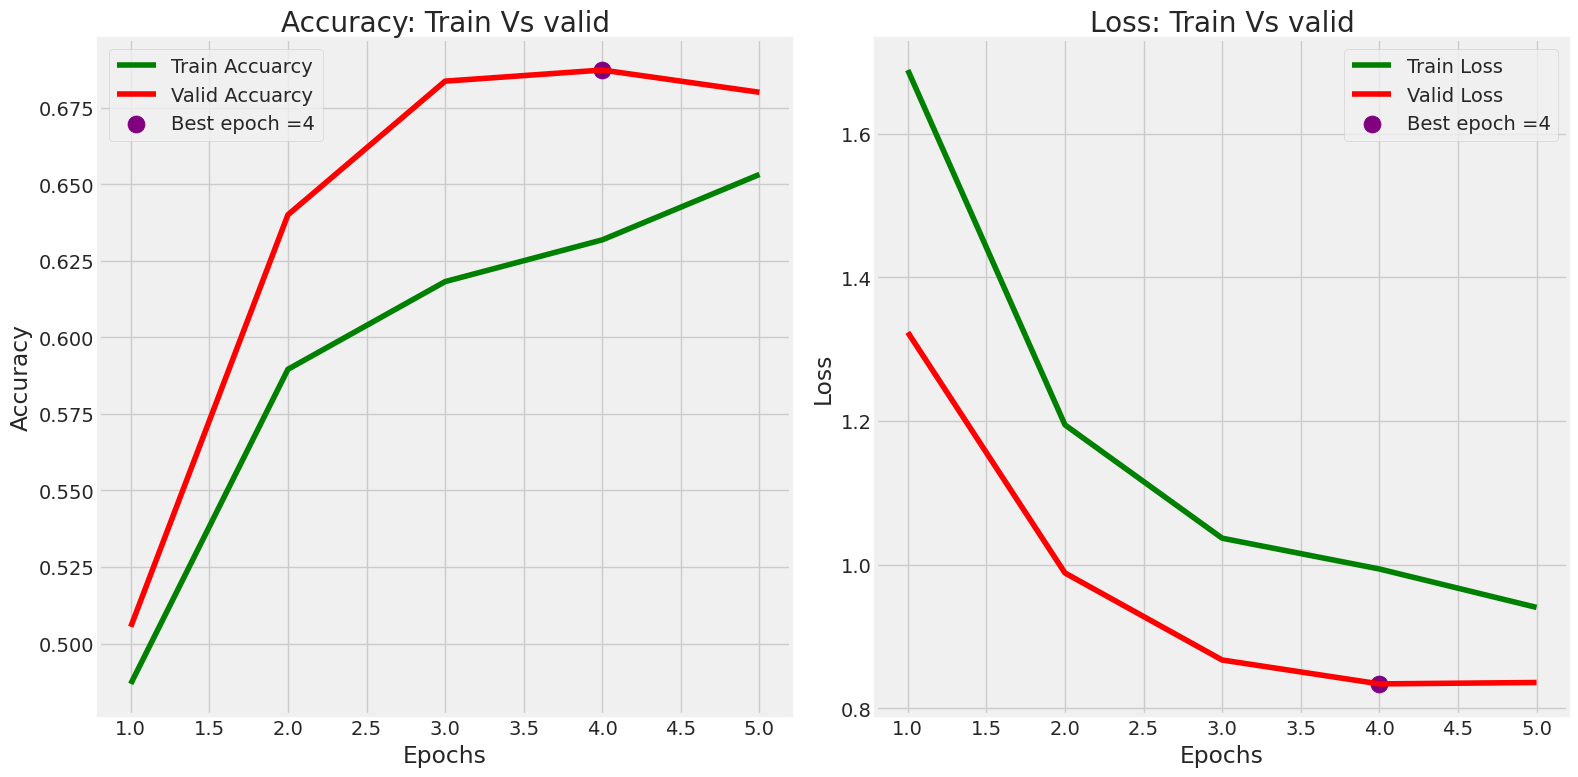

In [23]:
plt.figure(figsize = (16, 8))
plt.style.use('fivethirtyeight')


plt.subplot(1,2,1)
plt.plot(Epochs, tr_acc, "g", label = "Train Accuarcy")
plt.plot(Epochs, v_acc, "r", label = "Valid Accuarcy")
plt.scatter(index_acc+1, high_Vacc, s= 150, color = 'purple', label = best_acc)

plt.title("Accuracy: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(Epochs, tr_loss, "g", label = "Train Loss")
plt.plot(Epochs, v_loss, "r", label = "Valid Loss")
plt.scatter(index_loss+1, low_Vloss, s= 150, color = 'purple', label = best_loss)

plt.title("Loss: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
# Define Vars
Train_sc = model.evaluate(Train, verbose = 1)
Valid_sc = model.evaluate(Valid, verbose = 1)
Test_sc =model.evaluate(Test, verbose = 1)

#Print
print('Train Scores : \n    accuracy:', Train_sc[1], '\n      Loss: ', Train_sc[0], '\n________________________')
print('Valid Scores : \n    accuracy:', Valid_sc[1], '\n      Loss: ', Valid_sc[0], '\n________________________')
print('Test Scores : \n    accuracy:', Test_sc[1], '\n      Loss: ', Test_sc[0], '\n________________________')

110/110 ━━━━━━━━━━━━━━━━━━━━ 300s 3s/step - acc: 0.7194 - loss: 0.7387
14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - acc: 0.6716 - loss: 0.7960
14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - acc: 0.6692 - loss: 0.8175
Train Scores : 
    accuracy: 0.7122727036476135 
      Loss:  0.7503287196159363 
________________________
Valid Scores : 
    accuracy: 0.6800000071525574 
      Loss:  0.8359652161598206 
________________________
Test Scores : 
    accuracy: 0.6654545664787292 
      Loss:  0.8543933629989624 
________________________


# 5 Get  predictions

In [25]:
predictions = model.predict(Test)
y_pred = np.argmax(predictions, axis = 1)

#Chack
print(predictions)
print(y_pred)

14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step
[[0.9789715  0.01102583 0.00428945 0.00318242 0.00253064]
 [0.93393314 0.02752293 0.00852609 0.02478906 0.0052287 ]
 [0.00581529 0.16087767 0.65827674 0.01912299 0.1559072 ]
 ...
 [0.00845012 0.6775887  0.2724227  0.03362792 0.00791056]
 [0.40780938 0.04754045 0.44780064 0.04895834 0.04789122]
 [0.00126167 0.01398323 0.8828101  0.03854218 0.06340283]]
[0 0 2 1 1 1 2 1 0 1 1 0 0 2 1 1 1 1 1 0 0 0 0 1 2 1 2 2 1 1 2 1 0 2 0 2 2
 2 2 1 0 0 1 1 2 1 0 2 0 2 2 1 2 2 1 0 2 0 1 2 2 2 1 2 0 1 0 0 0 2 0 2 0 0
 1 2 1 1 0 0 2 1 0 1 0 1 0 2 1 1 2 1 2 1 0 0 1 2 1 2 1 1 2 2 0 0 0 0 2 2 2
 0 2 2 0 1 0 2 2 2 0 1 1 1 1 0 1 0 0 2 0 1 0 1 2 2 0 0 2 1 0 1 0 0 0 0 0 0
 0 2 0 0 0 0 1 0 0 2 1 2 2 0 2 1 1 2 0 0 1 0 2 0 2 2 2 2 0 0 0 2 1 1 0 1 0
 1 0 2 2 1 1 0 2 0 0 2 2 2 1 1 2 1 0 2 0 2 1 2 2 0 1 0 2 1 0 0 1 0 0 0 2 2
 2 2 2 2 2 2 2 0 2 0 0 0 0 2 0 0 1 2 0 0 2 2 0 1 0 0 1 0 0 1 1 1 0 0 0 0 1
 1 2 1 2 4 1 2 2 1 0 0 1 1 1 2 2]


In [26]:
# Use n. of keys of  Class indices to greate confusion matrix
Test_cl_ind = Test.class_indices

# Get Keys
classes = list(Test_cl_ind.keys())

#CM
cm = confusion_matrix(Test.classes, y_pred)
cm

array([[91,  6,  2,  0,  0],
       [ 5, 34,  7,  0,  0],
       [ 4, 29, 57,  0,  0],
       [ 2,  8, 12,  0,  0],
       [ 1,  4, 12,  0,  1]])

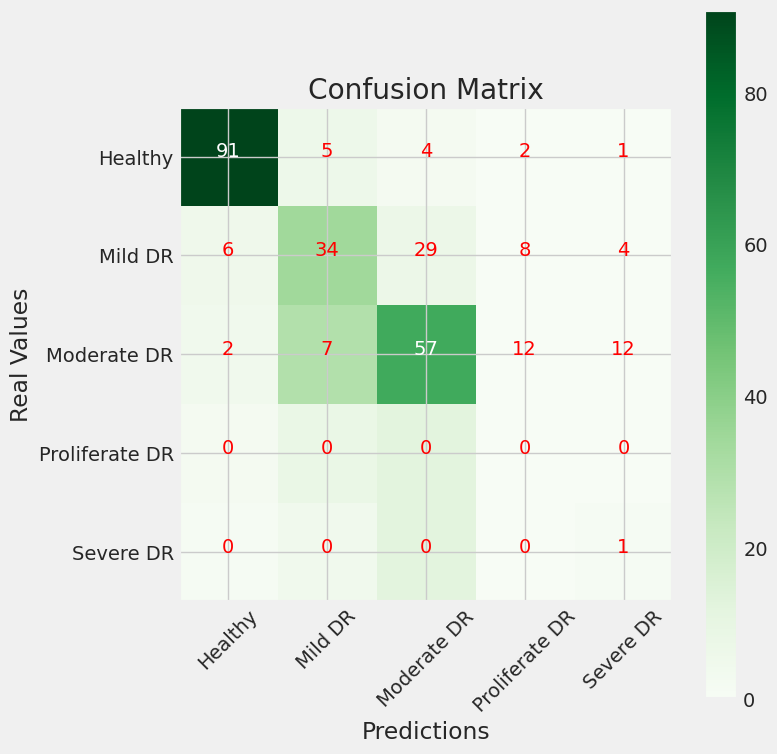

In [27]:
#visualise it
plt.figure(figsize =(8, 8))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,rotation = 45)
plt.yticks(tick_marks, classes)

thresh = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(i, j, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i,j] > thresh  else 'red')

plt.tight_layout()
plt.xlabel('Predictions')
plt.ylabel('Real Values')
plt.show()

In [ ]:
# Calssification Report
print(classification_report(Test.classes, y_pred, target_names = classes))


# 7 Save model

In [ ]:
model.save('effB3 CNN DR.h5')